### Imports

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from minisom import MiniSom
import warnings

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

2023-07-31 19:20:00.177764: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 19:20:00.220673: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 19:20:00.221974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 19:20:01.233018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Datasets

In [72]:
test = pd.read_csv("test_dataset.csv")
train = pd.read_csv("training_dataset.csv")
validation = pd.read_csv("validation_dataset.csv")

In [73]:
Cover_Type_Labels = [
    "Spruce",
    "Lodgepole",
    "Ponderosa",
    "Willow",
    "Aspen",
    "Douglas",
    "Krummholz",
]

### Data Cleaning

In [74]:
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)
validation.drop("Id", axis=1, inplace=True)

### Functions

In [6]:
def plot_best_n(
    n_range: list,
    test_acc_scores: list,
    train_acc_scores: list,
    value: str = "Features",
    classifier: str = "Classifier",
    baseline: float = None,
    baseline_name: str = None,
):
    """Plots the best number of features for a given classifier

    Parameters
    ----------
    n_range : list
        List of number of features
    test_acc_scores : list
        List of test accuracy scores
    train_acc_scores : list
        List of train accuracy scores
    value : str, optional
        The value to be plotted, by default "Features"
    classifier : str, optional
        The classifier used, by default "Classifier"
    baseline : float, optional
        The baseline model accuracy score, by default None
    baseline_name : str, optional
        The name of the baseline model, by default None
    """
    print(f"Best Test Accuracy Score: {max(test_acc_scores)}")
    print(f"Best Train Accuracy Score: {max(train_acc_scores)}")
    print(f"Best Number of {value} (acc): {n_range[np.argmax(test_acc_scores)]}")

    plt.figure(figsize=(6, 4))
    if baseline:
        plt.axhline(
            baseline, label=f"{baseline_name} Baseline", color="red", linestyle="--"
        )
    plt.plot(n_range, test_acc_scores, label="Test Score", color="green")
    plt.plot(n_range, train_acc_scores, label="Train Score", color="blue")
    plt.scatter(
        n_range[np.argmax(test_acc_scores)],
        max(test_acc_scores),
        marker="x",
        color="green",
    )
    plt.scatter(
        n_range[np.argmax(train_acc_scores)],
        max(train_acc_scores),
        marker="x",
        color="blue",
    )
    plt.annotate(
        f"({n_range[np.argmax(test_acc_scores)]}, {max(test_acc_scores):.3f})",
        xy=(n_range[np.argmax(test_acc_scores)], max(test_acc_scores)),
    )
    plt.annotate(
        f"({n_range[np.argmax(train_acc_scores)]}, {max(train_acc_scores):.3f})",
        xy=(n_range[np.argmax(train_acc_scores)], max(train_acc_scores)),
    )
    plt.legend()
    plt.title(f"Accuracy Scores vs {value} ({classifier})")
    plt.xlabel(value)
    plt.ylabel("Accuracy Score")
    plt.show()

In [44]:
def plot_cm(
    y_test,
    y_test_pred,
    y_val,
    y_val_pred,
    model_name,
    _feature_engineering=None,
):
    """Plot confusion matrices for test and validation sets.

    Parameters
    ----------
    y_test : array-like
        True labels for test set.
    y_test_pred : array-like
        Predicted labels for test set.
    y_val : array-like
        True labels for validation set.
    y_val_pred : array-like
        Predicted labels for validation set.
    model_name : str
        Name of model.
    _feature_engineering : str, optional
        Name of feature engineering method, by default None.
    """
    test_acc = accuracy_score(y_test, y_test_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    print(
        f"{model_name}{' w/ ' + _feature_engineering if _feature_engineering else ''} Test Accuracy: {test_acc:.3f}"
    )
    print(
        f"{model_name}{' w/ ' + _feature_engineering if _feature_engineering else ''} Train Accuracy: {val_acc:.3f}"
    )

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    ax1 = sns.heatmap(
        confusion_matrix(y_test, y_test_pred),
        annot=True,
        cmap="Greens",
        fmt="d",
        xticklabels=Cover_Type_Labels,
        yticklabels=Cover_Type_Labels,
        ax=axes[0],
    )
    ax1.set_title(
        f"Test Confusion Matrix, {model_name}{' w/ ' + _feature_engineering if _feature_engineering else ''} [{test_acc:.3f}]"
    )
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")

    ax2 = sns.heatmap(
        confusion_matrix(y_val, y_val_pred),
        annot=True,
        cmap="Greens",
        fmt="d",
        xticklabels=Cover_Type_Labels,
        yticklabels=Cover_Type_Labels,
        ax=axes[1],
    )
    ax2.set_title(
        f"Train Confusion Matrix, {model_name}{' w/ ' + _feature_engineering if _feature_engineering else ''} [{val_acc:.3f}]"
    )
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("Actual")

    plt.show()

## Models

In [32]:
models = [
    KNeighborsClassifier(),
    svm.SVC(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    GaussianNB(),
]

model_names = ["KNN", "SVM", "LR", "DT", "NB"]

In [33]:
X_train = train.drop("Cover_Type", axis=1)
y_train = train["Cover_Type"] - 1
X_test = test.drop("Cover_Type", axis=1)
y_test = test["Cover_Type"] - 1
X_val = validation.drop("Cover_Type", axis=1)
y_val = validation["Cover_Type"] - 1

### Baseline (Q1)

KNN => Test:0.738, Train:0.885, Val:0.752
SVM => Test:0.561, Train:0.686, Val:0.550
LR => Test:0.474, Train:0.578, Val:0.477
DT => Test:0.756, Train:1.000, Val:0.759
NB => Test:0.601, Train:0.642, Val:0.599


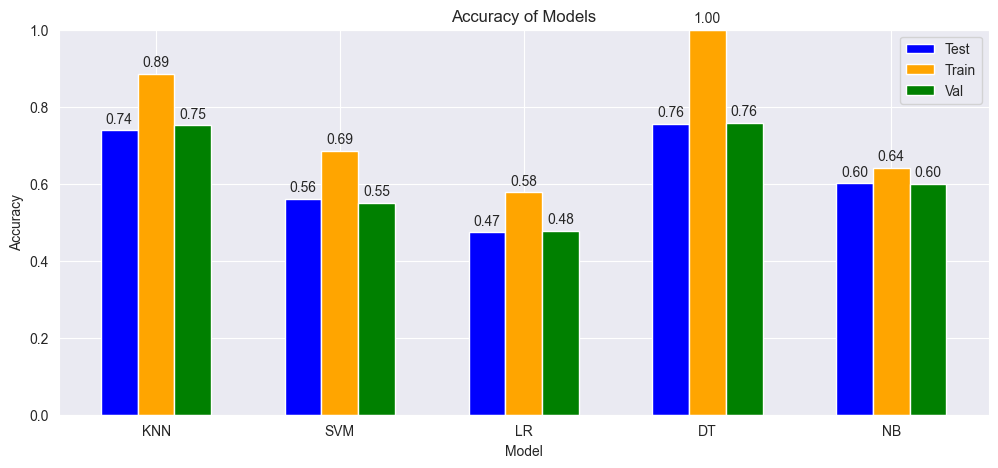

In [34]:
baseline_accuracy = dict.fromkeys(model_names)

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    test_acc = accuracy_score(y_test, model.predict(X_test))
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_val, model.predict(X_val))
    baseline_accuracy[name] = (test_acc, train_acc, val_acc)
    print(f"{name} => Test:{test_acc:.3f}, Train:{train_acc:.3f}, Val:{val_acc:.3f}")

plt.figure(figsize=(12, 5))
bar_width = 0.2
index = np.arange(len(model_names))

test_accuracies = [baseline_accuracy[name][0] for name in model_names]
train_accuracies = [baseline_accuracy[name][1] for name in model_names]
val_accuracies = [baseline_accuracy[name][2] for name in model_names]

bars_train = plt.bar(
    index,
    test_accuracies,
    width=bar_width,
    label="Test",
    color="blue",
)
bars_test = plt.bar(
    index + bar_width,
    train_accuracies,
    width=bar_width,
    label="Train",
    color="orange",
)
bars_val = plt.bar(
    index + 2 * bar_width,
    val_accuracies,
    width=bar_width,
    label="Val",
    color="green",
)

for bar in [bars_train, bars_test, bars_val]:
    for rect in bar:
        height = rect.get_height()
        plt.annotate(
            f"{height:.2f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

plt.xticks(index + bar_width, model_names)
plt.legend()
plt.title("Accuracy of Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

KNN Test Accuracy: 0.738
KNN Train Accuracy: 0.752


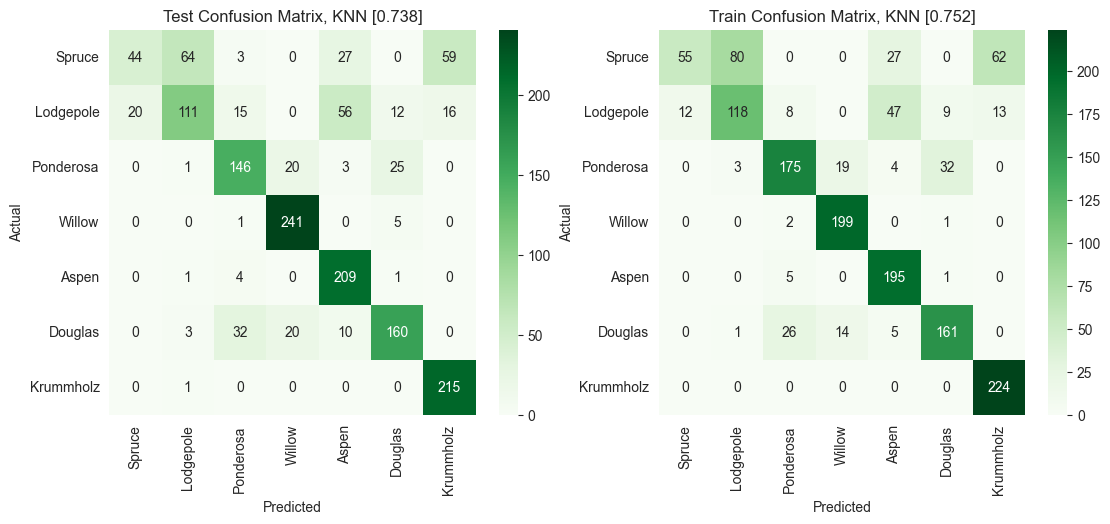

SVM Test Accuracy: 0.561
SVM Train Accuracy: 0.550


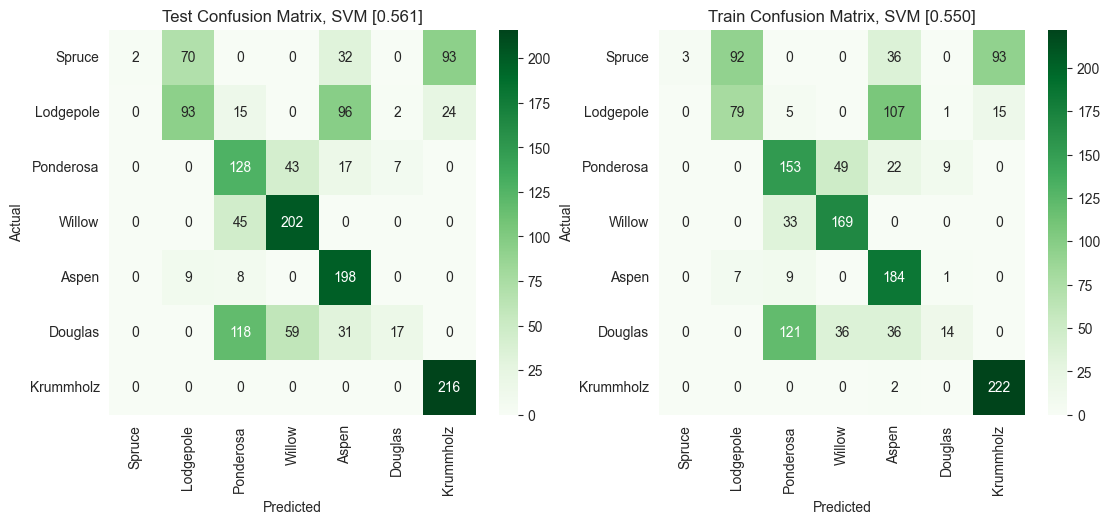

LR Test Accuracy: 0.474
LR Train Accuracy: 0.477


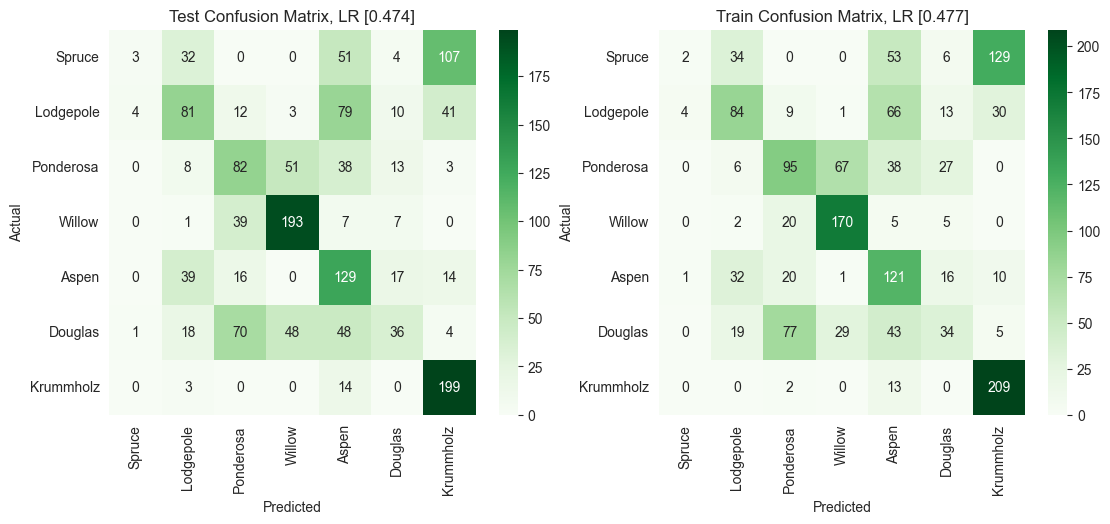

DT Test Accuracy: 0.761
DT Train Accuracy: 0.757


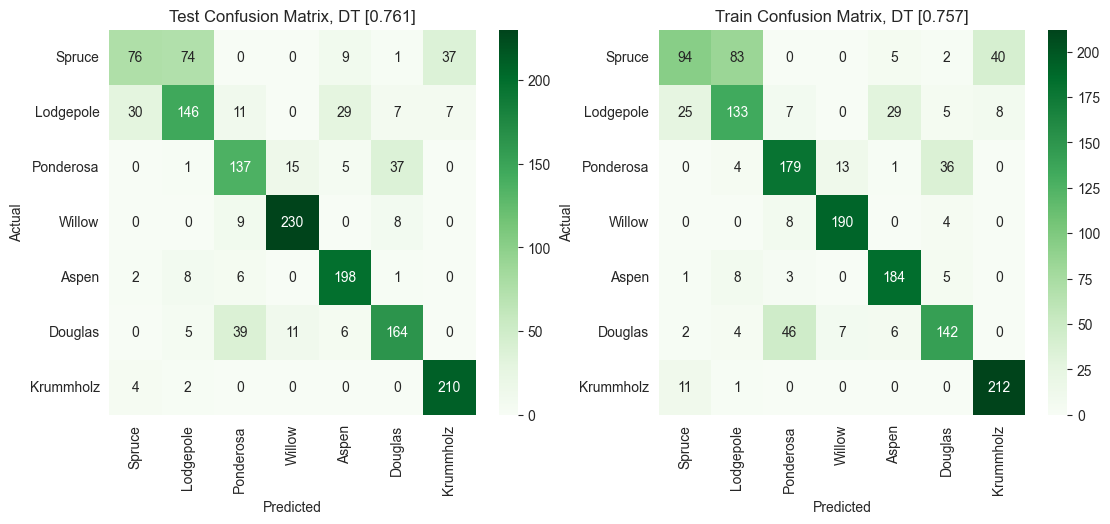

NB Test Accuracy: 0.601
NB Train Accuracy: 0.599


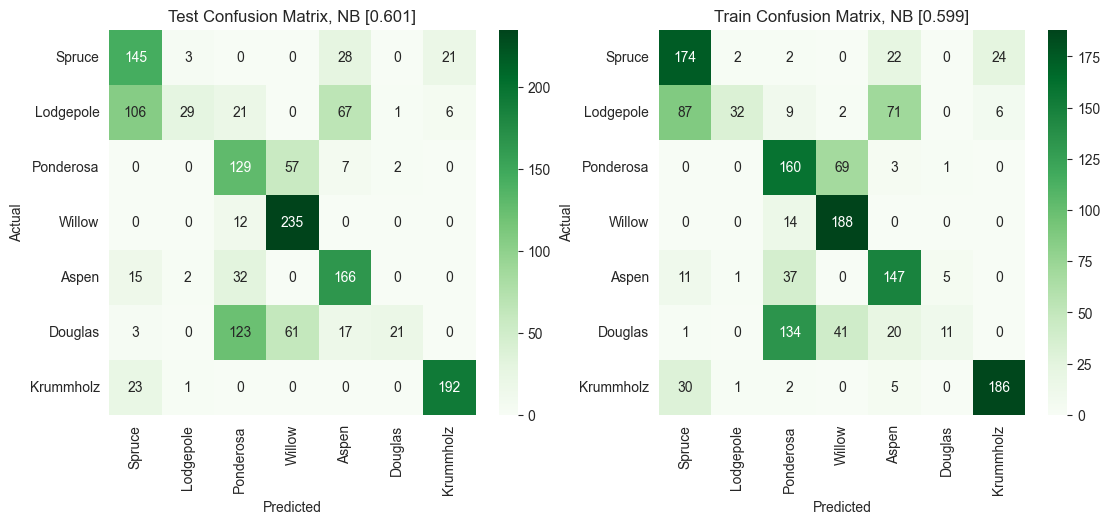

In [41]:
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_val = model.predict(X_val)
    plot_cm(y_test, y_pred_test, y_val, y_pred_val, model_name=name)

Best models are KNN (.738) and Decision Tree (.764)

## Feature Engineering

### Sampling

### First Improvement (Q2)

#### Filter Method, Variance Threshold

Best Test Accuracy Score: 0.7383606557377049
Best Train Accuracy Score: 0.8853487810765146
Best Number of Threshold (acc): 0.0


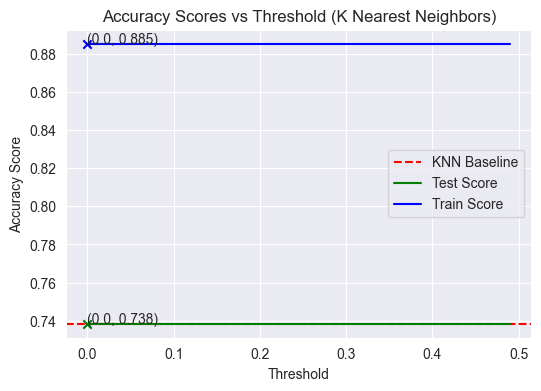

In [14]:
threshold_range = np.arange(0.0, 0.5, 0.01)
test_acc_scores = []
train_acc_scores = []
for thresh in threshold_range:
    vt = VarianceThreshold(threshold=thresh)
    vt.fit(X_train)
    X_train_vt = vt.transform(X_train)
    X_test_vt = vt.transform(X_test)
    X_val_vt = vt.transform(X_val)

    model = KNeighborsClassifier()
    model.fit(X_train_vt, y_train)
    test_acc_scores.append(accuracy_score(y_test, model.predict(X_test_vt)))
    train_acc_scores.append(accuracy_score(y_train, model.predict(X_train_vt)))

plot_best_n(
    threshold_range,
    test_acc_scores,
    train_acc_scores,
    value="Threshold",
    classifier="K Nearest Neighbors",
    baseline=baseline_accuracy["KNN"][0],
    baseline_name="KNN",
)

Best Test Accuracy Score: 0.7698360655737705
Best Train Accuracy Score: 1.0
Best Number of Threshold (acc): 0.041


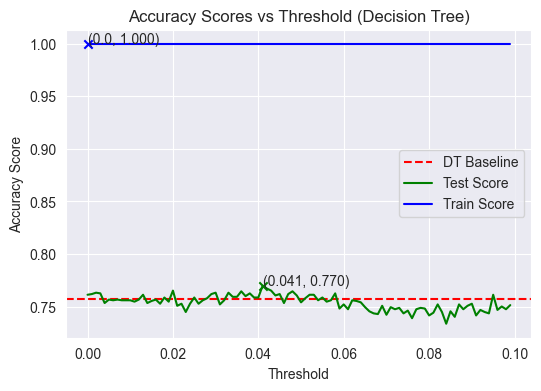

In [15]:
threshold_range = np.arange(0.0, 0.1, 0.001)
model = DecisionTreeClassifier()
test_acc_scores = []
train_acc_scores = []
for thresh in threshold_range:
    vt = VarianceThreshold(threshold=thresh)
    vt.fit(X_train)
    X_train_vt = vt.transform(X_train)
    X_test_vt = vt.transform(X_test)
    X_val_vt = vt.transform(X_val)

    model.fit(X_train_vt, y_train)
    test_acc_scores.append(accuracy_score(y_test, model.predict(X_test_vt)))
    train_acc_scores.append(accuracy_score(y_train, model.predict(X_train_vt)))

plot_best_n(
    threshold_range,
    test_acc_scores,
    train_acc_scores,
    value="Threshold",
    classifier="Decision Tree",
    baseline=baseline_accuracy["DT"][0],
    baseline_name="DT",
)

#### Wrapper Method, Recursive Feature Elimination

In [16]:
def knn_feature_importance(estimator):
    distances = estimator.kneighbors(None, n_neighbors=1)
    distances = np.sort(distances, axis=1)
    importances = 1 - distances[:, 0]
    return importances

Best Test Accuracy Score: 0.7383606557377049
Best Train Accuracy Score: 0.8853487810765146
Best Number of Features (acc): 54


<Figure size 600x400 with 0 Axes>

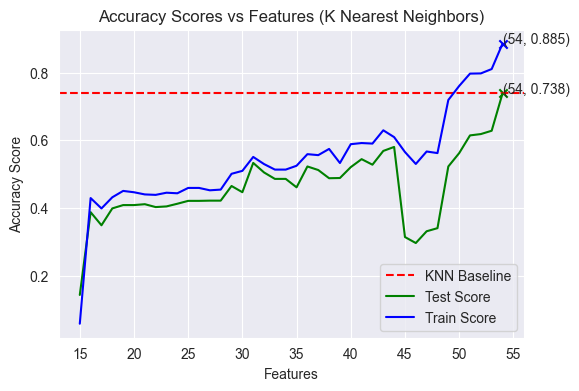

In [18]:
n_features_range = np.arange(15, len(X_train.columns) + 1)
test_acc_scores = []
train_acc_scores = []

for n_features in n_features_range:
    estimator = KNeighborsClassifier()
    rfe = RFE(
        estimator,
        n_features_to_select=n_features,
        importance_getter=knn_feature_importance,
        step=15,
    )

    rfe.fit(X_train, y_train)
    selected_features = X_train.columns[rfe.support_]
    estimator.fit(X_train[selected_features], y_train)
    test_acc_scores.append(
        accuracy_score(y_test, estimator.predict(X_test[selected_features]))
    )
    train_acc_scores.append(
        accuracy_score(y_train, estimator.predict(X_train[selected_features]))
    )

plt.figure(figsize=(6, 4))
plot_best_n(
    n_features_range,
    test_acc_scores,
    train_acc_scores,
    classifier="K Nearest Neighbors",
    baseline=baseline_accuracy["KNN"][0],
    baseline_name="KNN",
)

Best Test Accuracy Score: 0.7659016393442623
Best Train Accuracy Score: 1.0
Best Number of Features (acc): 40


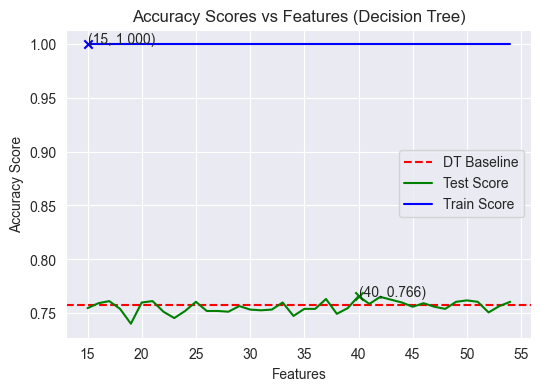

In [19]:
n_features_range = np.arange(15, len(X_train.columns) + 1)
test_acc_scores = []
train_acc_scores = []

for n_features in n_features_range:
    estimator = DecisionTreeClassifier()
    rfe = RFE(
        estimator,
        n_features_to_select=n_features,
    )

    rfe.fit(X_train, y_train)
    selected_features = X_train.columns[rfe.support_]
    estimator.fit(X_train[selected_features], y_train)
    test_acc_scores.append(
        accuracy_score(y_test, estimator.predict(X_test[selected_features]))
    )
    train_acc_scores.append(
        accuracy_score(y_train, estimator.predict(X_train[selected_features]))
    )

plot_best_n(
    n_features_range,
    test_acc_scores,
    train_acc_scores,
    classifier="Decision Tree",
    baseline=baseline_accuracy["DT"][0],
    baseline_name="DT",
)

#### CM for best two models

DT w/ VT Test Accuracy: 0.766
DT w/ VT Train Accuracy: 0.742


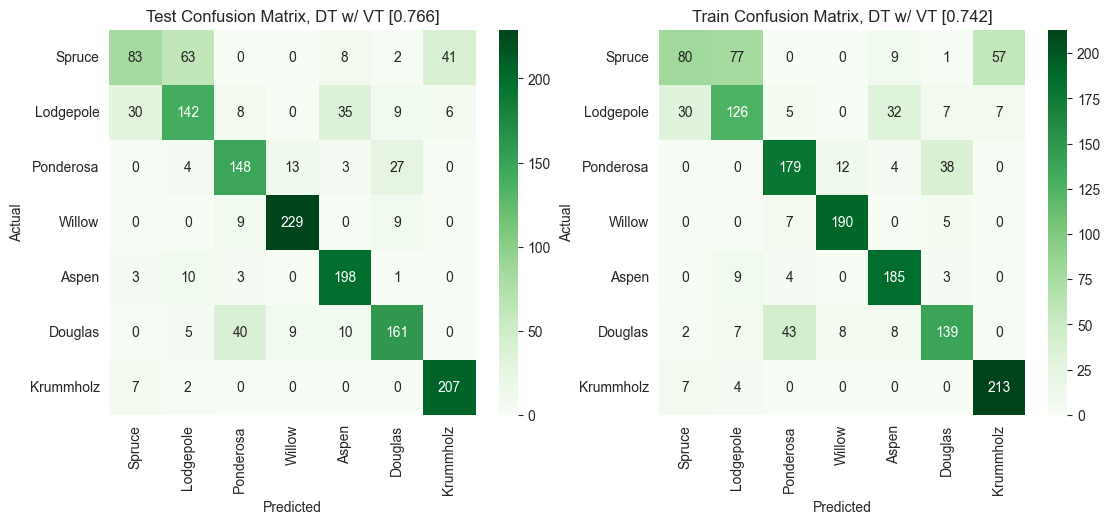

In [45]:
model = DecisionTreeClassifier()
vt = VarianceThreshold(threshold=0.041)
vt.fit(X_train)
X_train_vt = vt.transform(X_train)
X_test_vt = vt.transform(X_test)
X_val_vt = vt.transform(X_val)
model.fit(X_train_vt, y_train)
plot_cm(
    y_test,
    model.predict(X_test_vt),
    y_val,
    model.predict(X_val_vt),
    "DT",
    "VT",
)

DT w/ RFE Test Accuracy: 0.756
DT w/ RFE Train Accuracy: 0.754


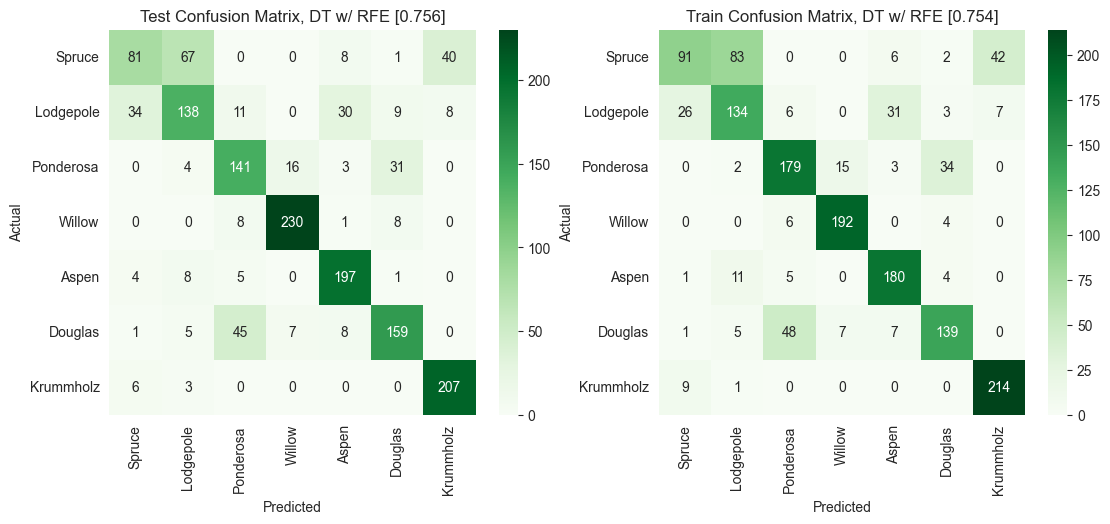

In [46]:
model = DecisionTreeClassifier()
rfe = RFE(model, n_features_to_select=40)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
model.fit(X_train[selected_features], y_train)
plot_cm(
    y_test,
    model.predict(X_test[selected_features]),
    y_val,
    model.predict(X_val[selected_features]),
    "DT",
    "RFE",
)

Best models are Decision Tree w/ RFE n = 41 (0.765) and Decision Tree w/ VT threshold = .05 (.764)

### Second Improvement (Q3)

In [79]:
ensemble_models = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

ensemble_model_names = ["RF", "AB", "GB"]

RF => Test:0.806, Train:1.000, Val:0.806
AB => Test:0.344, Train:0.391, Val:0.356
GB => Test:0.769, Train:0.892, Val:0.780


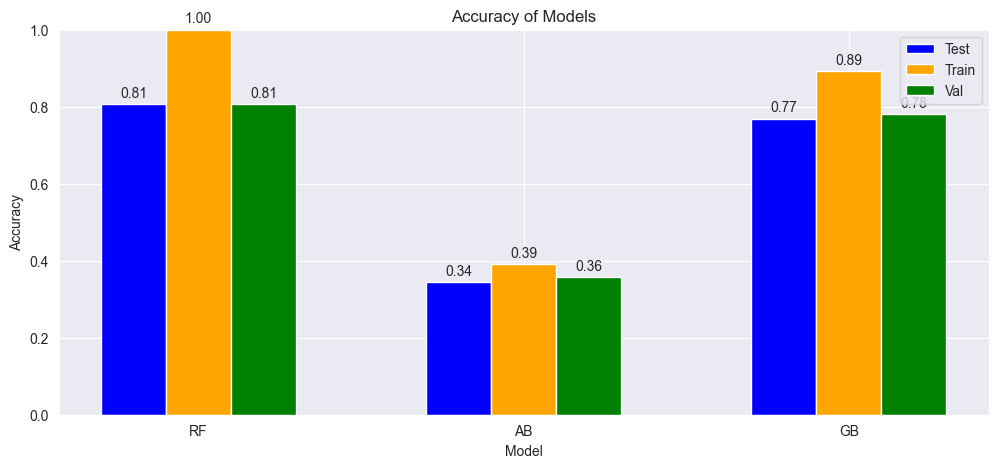

In [80]:
ensemble_baseline_accuracy = dict.fromkeys(ensemble_model_names)

for ensemble_model, name in zip(ensemble_models, ensemble_model_names):
    ensemble_model.fit(X_train, y_train)
    test_acc = accuracy_score(y_test, ensemble_model.predict(X_test))
    val_acc = accuracy_score(y_val, ensemble_model.predict(X_val))
    train_acc = accuracy_score(y_train, ensemble_model.predict(X_train))
    ensemble_baseline_accuracy[name] = (test_acc, train_acc, val_acc)
    print(f"{name} => Test:{test_acc:.3f}, Train:{train_acc:.3f}, Val:{val_acc:.3f}")

plt.figure(figsize=(12, 5))
bar_width = 0.2
index = np.arange(len(ensemble_model_names))

test_accuracies = [ensemble_baseline_accuracy[name][0] for name in ensemble_model_names]
train_accuracies = [
    ensemble_baseline_accuracy[name][1] for name in ensemble_model_names
]
val_accuracies = [ensemble_baseline_accuracy[name][2] for name in ensemble_model_names]

bars_train = plt.bar(
    index,
    test_accuracies,
    width=bar_width,
    label="Test",
    color="blue",
)
bars_test = plt.bar(
    index + bar_width,
    train_accuracies,
    width=bar_width,
    label="Train",
    color="orange",
)
bars_val = plt.bar(
    index + 2 * bar_width,
    val_accuracies,
    width=bar_width,
    label="Val",
    color="green",
)

for bar in [bars_train, bars_test, bars_val]:
    for rect in bar:
        height = rect.get_height()
        plt.annotate(
            f"{height:.2f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

plt.xticks(index + bar_width, ensemble_model_names)
plt.legend()
plt.title("Accuracy of Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

RF Test Accuracy: 0.801
RF Train Accuracy: 0.812


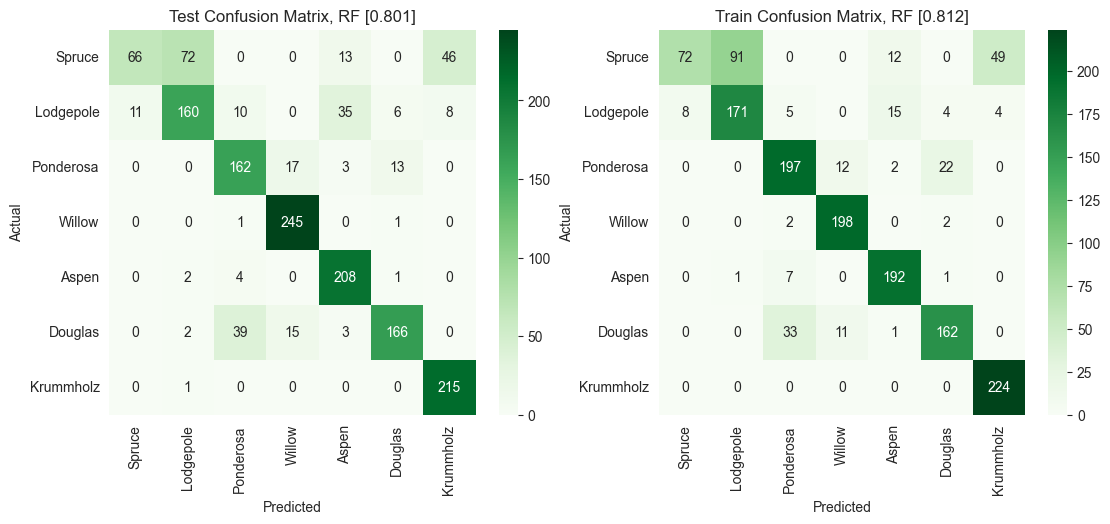

AB Test Accuracy: 0.344
AB Train Accuracy: 0.356


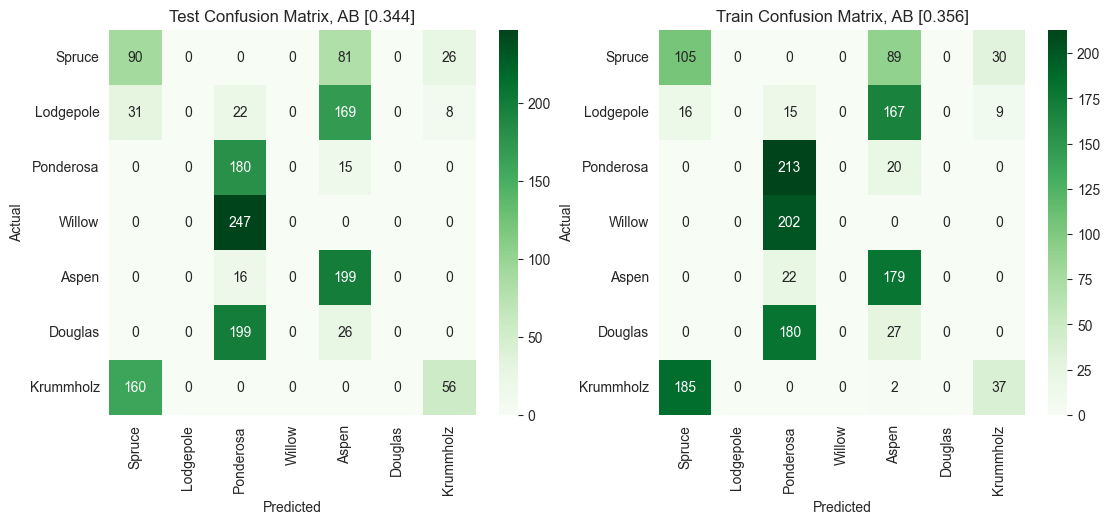

GB Test Accuracy: 0.770
GB Train Accuracy: 0.780


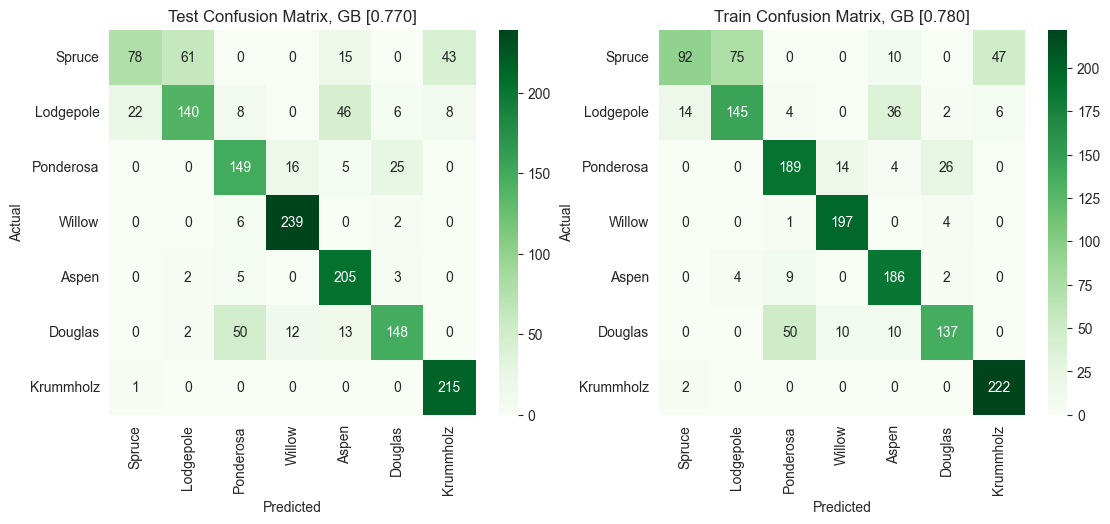

In [48]:
for model, name in zip(ensemble_models, ensemble_model_names):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_val = model.predict(X_val)
    plot_cm(y_test, y_pred_test, y_val, y_pred_val, model_name=name)

Best models are Random Forest (.81) and Gradient Boosting (.77)

### Supervise & Unsupervised Combination via PKI (Q4)

In [49]:
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train.values)
X_test_np = scaler.transform(X_test.values)
X_val_np = scaler.transform(X_val.values)

#### Functions

In [50]:
def pki_transform(X, som, y_pred):
    """Transforms the data by adding the SOM grid coordinates and the predicted labels from the supervised model

    Parameters
    ----------
    X : pd.DataFrame
        The data to be transformed
    som : MiniSom
        The SOM to be used
    y_pred : np.array
        predicted labels from supervised model

    Returns
    -------
    X_transformed : pd.DataFrame
        The transformed data
    """
    som_grid_flat = np.array([som.winner(x) for x in X])
    som_grid_mapped = som_grid_flat[:, 0] * som._weights.shape[1] + som_grid_flat[:, 1]
    X_combined = np.hstack([X, som_grid_mapped.reshape(-1, 1), y_pred.reshape(-1, 1)])
    X_transformed = pd.DataFrame(X_combined)
    return X_transformed

#### Random Forest Best Parameters

#### Deep Learning

In [82]:
def create_model(hidden_layer_dim, meta, activ):
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]
    model = Sequential()
    model.add(Dense(n_features_in_, input_shape=X_shape_[1:]))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(hidden_layer_dim, activation=activ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(hidden_layer_dim, activation=activ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(hidden_layer_dim, activation=activ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(hidden_layer_dim, activation=activ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(n_classes_, activation="softmax"))
    return model

Best Test Accuracy Score: 0.8059016393442623
Best Train Accuracy Score: 0.9831040308954864
Best Number of SOM Size (acc): 8


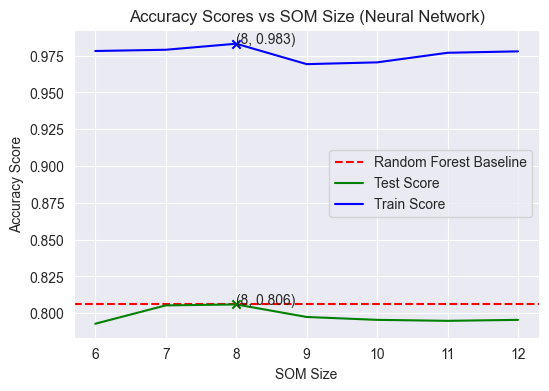

In [83]:
sizes_to_evaluate = [(6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12)]
model = KerasClassifier(
    create_model,
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    hidden_layer_dim=30,
    activ="tanh",
    verbose=0,
)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
train_pred_supervised = rf.predict(X_train)
val_pred_supervised = rf.predict(X_val)
test_pred_supervised = rf.predict(X_test)
nn_test_acc_scores = []
nn_train_acc_scores = []

for size in sizes_to_evaluate:
    som = MiniSom(size[0], size[1], input_len=X_train_np.shape[1])
    som.random_weights_init(X_train_np)
    som.train_batch(X_train_np, num_iteration=100)

    X_train_pki = pki_transform(X_train_np, som, train_pred_supervised)
    X_val_pki = pki_transform(X_val_np, som, val_pred_supervised)

    # Sampling 20% of the data to speed up training
    X_train_pki_sample, _, y_train_sample, _ = train_test_split(
        X_train_pki, y_train, test_size=0.8, stratify=y_train
    )
    X_val_pki_sample, _, y_val_sample, _ = train_test_split(
        X_val_pki, y_val, test_size=0.8, stratify=y_val
    )

    X_test_pki = pki_transform(X_test_np, som, test_pred_supervised)

    model.fit(
        X_train_pki_sample,
        y_train_sample,
        epochs=100,
        validation_data=(X_val_pki_sample, y_val_sample),
    )

    nn_test_acc_scores.append(accuracy_score(y_test, model.predict(X_test_pki)))
    nn_train_acc_scores.append(accuracy_score(y_train, model.predict(X_train_pki)))

plot_best_n(
    [size[0] for size in sizes_to_evaluate],
    nn_test_acc_scores,
    nn_train_acc_scores,
    value="SOM Size",
    classifier="Neural Network",
    baseline=ensemble_baseline_accuracy["RF"][0],
    baseline_name="Random Forest",
)

In [68]:
best_size = sizes_to_evaluate[np.argmax(nn_test_acc_scores)]

som = MiniSom(best_size[0], best_size[1], input_len=X_train_np.shape[1])
som.random_weights_init(X_train_np)
som.train_batch(X_train_np, num_iteration=100)

X_train_pki = pki_transform(X_train_np, som, train_pred_supervised)
X_val_pki = pki_transform(X_val_np, som, val_pred_supervised)
X_test_pki = pki_transform(X_test_np, som, test_pred_supervised)

# Sampling 20% of the data to speed up training
X_train_pki_sample, _, y_train_sample, _ = train_test_split(
    X_train_pki, y_train, test_size=0.8, stratify=y_train
)
X_val_pki_sample, _, y_val_sample, _ = train_test_split(
    X_val_pki, y_val, test_size=0.8, stratify=y_val
)

params = {
    "hidden_layer_dim": [60],
    "batch_size": [16, 32],
    "epochs": [150, 200],
    "activ": ["relu", "tanh"],
}

model = KerasClassifier(
    create_model,
    loss="sparse_categorical_crossentropy",
    hidden_layer_dim=30,
    optimizer=Adam(learning_rate=0.0005),
    activ="tanh",
    verbose=0,
)

nn_grid = GridSearchCV(model, params, cv=2, verbose=1, n_jobs=-1)
nn_grid.fit(
    X_train_pki_sample,
    y_train_sample,
    validation_data=(X_val_pki_sample, y_val_sample),
)

print(f"Best Parameters: {nn_grid.best_params_}")
print(f"Best Accuracy: {nn_grid.best_score_}")

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best Parameters: {'activ': 'relu', 'batch_size': 16, 'epochs': 200, 'hidden_layer_dim': 60}
Best Accuracy: 0.9861249511954919


Neural Network w/ SOM+RF PKI Test Accuracy: 0.813
Neural Network w/ SOM+RF PKI Train Accuracy: 0.813


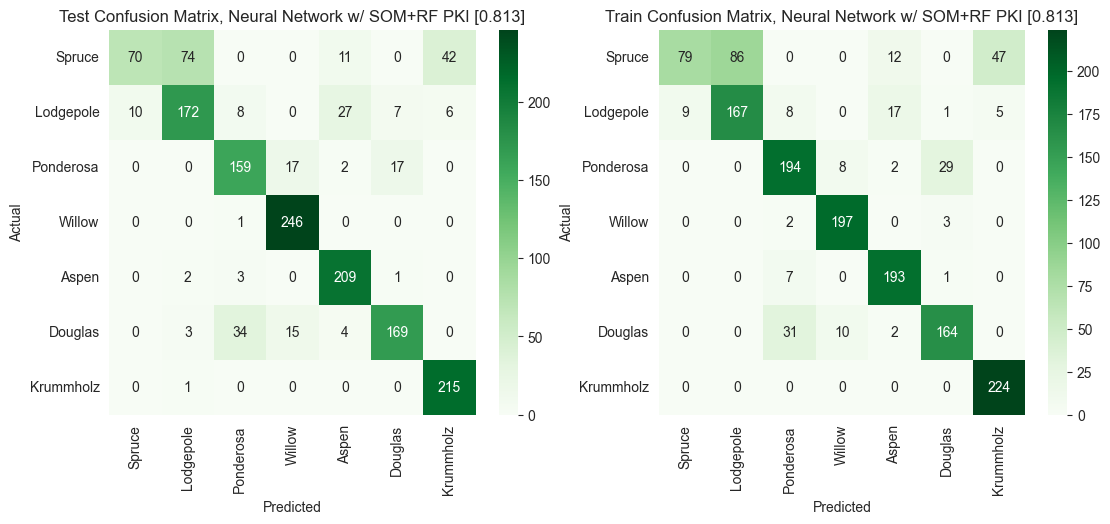

In [69]:
model = nn_grid.best_estimator_

model.fit(
    X_train_pki,
    y_train,
    validation_data=(X_val_pki, y_val),
)
plot_cm(
    y_test,
    model.predict(X_test_pki),
    y_val,
    model.predict(X_val_pki),
    "Neural Network",
    "SOM+RF PKI",
)

Neural Network w/ SOM+RF PKI Test Accuracy: 0.813
Neural Network w/ SOM+RF PKI Train Accuracy: 0.999


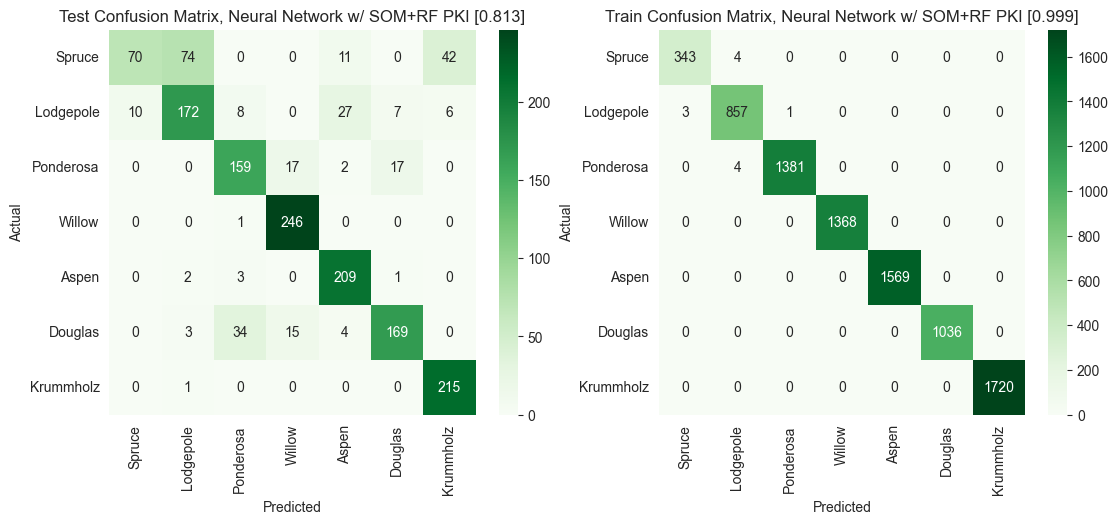

In [70]:
plot_cm(
    y_test,
    model.predict(X_test_pki),
    y_train,
    model.predict(X_train_pki),
    "Neural Network",
    "SOM+RF PKI",
)